# Project 1 - Probably Interesting Data.
 - EECS 738 Project 1
 - Author: Ashwin Rathore

## Problem Statement
### Distribution estimation
1. Set up a new git repository in your GitHub account
2. Pick two datasets from https://www.kaggle.com/uciml/datasets
3. Choose a programming language (Python, C/C++, Java)
4. Formulate ideas on how machine learning can be used to model distributions within the dataset
5. Build a heuristic and/or algorithm to model the data using mixture models of probability distributions programmatically
6. Document your process and results
7. Commit your source code, documentation and other supporting files to the git repository in GitHub

## Goal
Our goal is to build a heuristic and/or algorithm to model the data using mixture models of probability distributions programmatically

Import all libraries and data from the file.

In [72]:
import pandas as pd
import numpy as np
import random as rand
import matplotlib.pyplot as plt
from scipy.stats import norm
from sys import maxsize

Importing the data from Haberman.data file in to pandas dataframe

In [ ]:
df = pd.read_csv(r'C:\Stuff\KU Study\EECS 738 Machine Learning\Projects\Project 1 - Probably Interesting Data\data\external\haberman.data')

Let's check the top rows of the dataset.

In [73]:
df.head()

,age_of_patient,year_of_operation,no_of_positive_axillary_nodes_detected,survival_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


#### Step 2: Data Analysis and Feature Engineering

Check the number of samples in the dataset

In [74]:
df.shape

(306, 4)

We have 306 samples in this dataset. 
Our goal is to build a heuristic and/or algorithm to model the data using mixture models of probability distributions programmatically.
Let's drop "year_of_operation"  and "survival_status" the columns and look at the dataset as we are going to apply Estimation Maximization algorithm based on the other two columns.

In [75]:
df = df.drop(["year_of_operation","survival_status"],axis='columns')
df.head()

,age_of_patient,no_of_positive_axillary_nodes_detected
0,30,1
1,30,3
2,30,0
3,31,2
4,31,4


Now we check the missing data in the dataset

In [76]:
df.isnull().sum()

age_of_patient                            0
no_of_positive_axillary_nodes_detected    0
dtype: int64

We are going to implement Gaussian Mixture model for this project. GMMs is probabilistic model that assumes all the data points are generated from a mixture of different Gaussian distributions with unknown parameters.
First we are going to intialize the parameters with some random values:
        lambda: initial probabilities of the clusters,
        myu: means of clusters ,
        sigma: standard Diviation of clusters for objects

In [151]:
initial = { 'myu1': [4,4],
          'sigma1': [ [0.5, 0.5], [0.5, 0.5] ],
          'myu2': [4,4],
          'sigma2': [ [0.5, 0.5], [0.5, 0.5] ],
          'lambda': [0.5, 0.5]
        }

The probability function that a point came from a Guassian with given parameters is defined.
The function takes each sample and calculate probability for each attribute

In [152]:
def probability(value, myu, sigma, lamb):
    # assigning probability to a local variable
  prob = lamb        
    #Looping over the values of attributes for a single sample to find the probability   
  for i in range(len(value)):
    #applying Probability distribution function to find the resulting probability
    prob *= norm.pdf(value[i], myu[i], sigma[i][i])
  return prob

Below is the Expectation function. It performs probabilistic assignments of each data point to some class based on the current hypothesis for the distributional class parameters. During this we are calculating the expected value of cluster assignments.

In [153]:
#The function takes dataframe and parameters which we defined earlier
def expectation(dF, parameters):
    #looping over the samples present in the Dataframe
  for i in range(dF.shape[0]):
    #taking the attribute values of current sample in the variables t and u
    t = dF['age_of_patient'][i]
    u = dF['no_of_positive_axillary_nodes_detected'][i]
    #passing the current sample's attribute values to the probability function along with the paramaters of each clusters
    #to calculate the probability of belonging of the sample to that cluster.
    p_cluster1 = probability([t, u], list(parameters['myu1']), list(parameters['sigma1']), parameters['lambda'][0] )
    p_cluster2 = probability([t, u], list(parameters['myu2']), list(parameters['sigma2']), parameters['lambda'][1] )
    #assigning the sample to the cluster whose probability is greater than the other. 
    if p_cluster1 > p_cluster2:
      dF['label'][i] = 1
    else:
      dF['label'][i] = 2
  return dF


Below is the maximization funtion. It updates the hypothesis for the distributional class parameters based on the new data assignments. During this we are calculating a new maximum likelihood for our hypothesis.

In [154]:
#The function takes dataframe and parameters which we defined earlier
def maximization(dF, parameters):
    #Separating the points in cluster 1 and cluster 2.
  points_cluster1 = dF.loc[dF['label'] == 1]
  points_cluster2 = dF.loc[dF['label'] == 2]  
    #Finding the percentage of points which belongs to the cluster1 and cluster2 with respect to the total samples.
  percent_cluster1 = len(points_cluster1) / float(len(dF))
  percent_cluster2 = 1 - percent_cluster1
    #Set up the lambda again
  parameters['lambda'] = [percent_cluster1, percent_cluster2 ]
    #Applying mean() function to calculate average of attributes and set the parameters
  parameters['myu1'] = [points_cluster1['age_of_patient'].mean(), points_cluster1['no_of_positive_axillary_nodes_detected'].mean()]
  parameters['myu2'] = [points_cluster2['age_of_patient'].mean(), points_cluster2['no_of_positive_axillary_nodes_detected'].mean()]
    #Applying  function std() to calculate standard deviation of attributes and set the parameters
  parameters['sigma1'] = [ [points_cluster1['age_of_patient'].std(), 0 ], [ 0, points_cluster1['no_of_positive_axillary_nodes_detected'].std() ] ]
  parameters['sigma2'] = [ [points_cluster2['age_of_patient'].std(), 0 ], [ 0, points_cluster2['no_of_positive_axillary_nodes_detected'].std() ] ]
  return parameters

Below we are defining a distance function to calculate distance between the old and new parameteres.

In [155]:
def distance(old_parameters, new_parameters):
  distance = 0
    #looping for myu1 and myu2
  for p in ['myu1', 'myu2']:
    #looping on old parameters
    for i in range(len(old_parameters)):
        #calculating distance between old and new parameters by squaring them to get positive values
      distance += (old_parameters[p][i] - new_parameters[p][i]) ** 2
    #returning the squareroot of distance to equalize the square in previous step.
  return distance ** 0.5

Initializing the variables needed for the algorithms loop

In [167]:
#maxsize attribute of the sys module fetches the largest value a variable which depends on the system architecture
max = maxsize
#eps has a minimum initial value
eps = 0.01
#number of iterations
iterations = 0
#copy of original dataframe
df_copy = df.copy()
# randomly assigning samples to on of the clusters
data = np.random.randint(1,3,size=306)
df_copy['label'] = pd.DataFrame(data)
print()
#df_copy['label'] = map(lambda x: x+1, np.random.choice(2, len(df)))
#creating parameters dataframe of the original dataframe
params = pd.DataFrame(maximization(df_copy,initial))

We are putting a while loop which will run untill the expectation of the distance between the parameters found out to be 0 or the parameters converges to the optimal values. We will be plotting the Graph with "age_of_patients" and 'no_of_positive_axillary_nodes_detected' features and the color of points in graph shows the cluster that the samples belong to.

In [ ]:
while max > eps:
  iterations += 1
  # Calling the expectation function.
  new_labels = expectation(df_copy.copy(), params)

  # Calling the maximization function
  new_parameters = maximization(new_labels, params.copy())

  # Calculating the difference between old and new parameters
  max = distance(params, new_parameters)

  # logging
  print("iteration {}, shift {}".format(iterations, max))

  # update labels and params for the next iteration
  df_copy = new_labels
  params = new_parameters
    #Plotting figure with label and attribute values
  fig = plt.figure()
  plt.scatter(df_copy['age_of_patient'], df_copy['no_of_positive_axillary_nodes_detected'], 24, c=df_copy['label'])
  fig.savefig("iteration{}.png".format(iterations))


Importing the data from Real_estate_valuation_data_set.csv file in to pandas dataframe

In [261]:
df = pd.read_csv(r'C:\Stuff\KU Study\EECS 738 Machine Learning\Projects\Project 1 - Probably Interesting Data\data\external\Real_estate_valuation_data_set.csv')

Let's check the top rows of the dataset.

In [262]:
df.head()

,No,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


#### Step 2: Data Analysis and Feature Engineering

Check the number of samples in the dataset

In [263]:
df.shape

(414, 8)

We have 414 samples in this dataset. 
Our goal is to build a heuristic and/or algorithm to model the data using mixture models of probability distributions programmatically.
Let's drop "transaction_date" , "latitude", "longitude" and "No" the columns and look at the dataset as we are going to apply Estimation Maximization algorithm based on the other two columns.

In [264]:
df = df.drop(["transaction_date","No","latitude", "longitude"],axis='columns')
df.head()

,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,house_price_of_unit_area
0,32.0,84.87882,10,37.9
1,19.5,306.59470,9,42.2
2,13.3,561.98450,5,47.3
3,13.3,561.98450,5,54.8
4,5.0,390.56840,5,43.1


Now we check the missing data in the dataset

In [265]:
df.isnull().sum()

house_age                              0
distance_to_the_nearest_MRT_station    0
number_of_convenience_stores           0
house_price_of_unit_area               0
dtype: int64

In [266]:
df.head()

,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,house_price_of_unit_area
0,32.0,84.87882,10,37.9
1,19.5,306.59470,9,42.2
2,13.3,561.98450,5,47.3
3,13.3,561.98450,5,54.8
4,5.0,390.56840,5,43.1


Let's change the data into int.

In [267]:
df=df.astype(int)
df.head()

,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,house_price_of_unit_area
0,32,84,10,37
1,19,306,9,42
2,13,561,5,47
3,13,561,5,54
4,5,390,5,43


We are going to implement Gaussian Mixture model for this project. GMMs is probabilistic model that assumes all the data points are generated from a mixture of different Gaussian distributions with unknown parameters.
First we are going to intialize the parameters with some random values:
        lambda: initial probabilities of the clusters,
        myu: means of clusters ,
        sigma: standard Diviation of clusters for objects

In [268]:
initial = { 'myu1': [1,1,1,1,1],
          'sigma1': [ [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]],
          'myu2': [4,4,4,4,4],
          'sigma2': [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]],
          'lambda': [0.4, 0.6, 0, 0, 0]
        }

The probability function that a point came from a Guassian with given parameters is defined.
The function takes each sample and calculate probability for each attribute

In [269]:
def probability(value, myu, sigma, lamb):
    # assigning probability to a local variable
  prob = lamb        
    #Looping over the values of attributes for a single sample to find the probability   
  for i in range(len(value)):
    #applying Probability distribution function to find the resulting probability
    prob *= norm.pdf(value[i], myu[i], sigma[i][i])
  return prob

Below is the Expectation function. It performs probabilistic assignments of each data point to some class based on the current hypothesis for the distributional class parameters. During this we are calculating the expected value of cluster assignments.

In [270]:
#The function takes dataframe and parameters which we defined earlier
def expectation(dF, parameters):
    #looping over the samples present in the Dataframe
  for i in range(dF.shape[0]):
    #taking the attribute values of current sample in the variables t and u
    w = dF['house_age'][i]
    x = dF['distance_to_the_nearest_MRT_station'][i]
    y = dF['number_of_convenience_stores'][i]
    z = dF['house_price_of_unit_area'][i]
    #passing the current sample's attribute values to the probability function along with the paramaters of each clusters
    #to calculate the probability of belonging of the sample to that cluster.
    p_cluster1 = probability([w, x, y, z], list(parameters['myu1']), list(parameters['sigma1']), parameters['lambda'][0] )
    p_cluster2 = probability([w, x, y, z], list(parameters['myu2']), list(parameters['sigma2']), parameters['lambda'][1] )
    #assigning the sample to the cluster whose probability is greater than the other. 
    if p_cluster1 > p_cluster2:
      dF['label'][i] = 1
    else:
      dF['label'][i] = 2
  return dF


Below is the maximization funtion. It updates the hypothesis for the distributional class parameters based on the new data assignments. During this we are calculating a new maximum likelihood for our hypothesis.

In [271]:
#The function takes dataframe and parameters which we defined earlier
def maximization(dF, parameters):
    #Separating the points in cluster 1 and cluster 2.
  points_cluster1 = dF.loc[dF['label'] == 1]
  points_cluster2 = dF.loc[dF['label'] == 2]  
    #Finding the percentage of points which belongs to the cluster1 and cluster2 with respect to the total samples.
  percent_cluster1 = len(points_cluster1) / float(len(dF))
  percent_cluster2 = 1 - percent_cluster1
    #Set up the lambda again
  parameters['lambda'] = [percent_cluster1, percent_cluster2, 0, 0]
    #Applying mean() function to calculate average of attributes and set the parameters
  parameters['myu1'] = [ points_cluster1['house_age'].mean(), points_cluster1['distance_to_the_nearest_MRT_station'].mean(), points_cluster1['number_of_convenience_stores'].mean(), points_cluster1['house_price_of_unit_area'].mean()]
  parameters['myu2'] = [ points_cluster2['house_age'].mean(), points_cluster2['distance_to_the_nearest_MRT_station'].mean(), points_cluster2['number_of_convenience_stores'].mean(), points_cluster2['house_price_of_unit_area'].mean()]
    #Applying  function std() to calculate standard deviation of attributes and set the parameters
  parameters['sigma1'] = [  [ points_cluster1['house_age'].std(), 0, 0, 0 ] , [ 0, points_cluster1['distance_to_the_nearest_MRT_station'].std(), 0, 0 ], [ 0, 0, points_cluster1['number_of_convenience_stores'].std(), 0,], [ 0, 0, 0, points_cluster1['house_price_of_unit_area'].std() ]]
  parameters['sigma2'] = [  [ points_cluster2['house_age'].std(), 0, 0, 0 ] , [ 0, points_cluster2['distance_to_the_nearest_MRT_station'].std(), 0, 0 ], [ 0, 0, points_cluster2['number_of_convenience_stores'].std(), 0,], [ 0, 0, 0, points_cluster2['house_price_of_unit_area'].std() ]]
  return parameters

Below we are defining a distance function to calculate distance between the old and new parameteres.

In [272]:
def distance(old_parameters, new_parameters):
  distance = 0
    #looping for myu1 and myu2
  for p in ['myu1', 'myu2']:
    #looping on old parameters
    for i in range(len(old_parameters)):
        #calculating distance between old and new parameters by squaring them to get positive values
      distance += (old_parameters[p][i] - new_parameters[p][i]) ** 2
    #returning the squareroot of distance to equalize the square in previous step.
  return distance ** 0.5

Initializing the variables needed for the algorithms loop

In [276]:
#maxsize attribute of the sys module fetches the largest value a variable which depends on the system architecture
max = maxsize
#eps has a minimum initial value
eps = 0.01
#number of iterations
iterations = 0
#copy of original dataframe
df_copy = df.copy()
# randomly assigning samples to on of the clusters
data = np.random.randint(1,3,size=414)
df_copy['label'] = pd.DataFrame(data)
print()
#df_copy['label'] = map(lambda x: x+1, np.random.choice(2, len(df)))
#creating parameters dataframe of the original dataframe
params = pd.DataFrame(maximization(df_copy,initial))

We are putting a while loop which will run untill the expectation of the distance between the parameters found out to be 0 or the parameters converges to the optimal values. We will be plotting the Graph with "house_price_of_unit_area" and 'house_age' features and the color of points in graph shows the cluster that the samples belong to.

iteration 2, shift 133.14579295236658
iteration 3, shift 12.814847506234496
iteration 4, shift 0.0


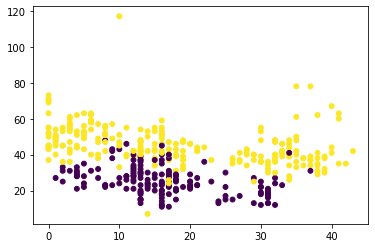

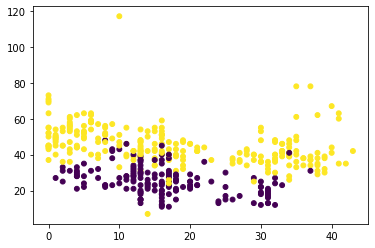

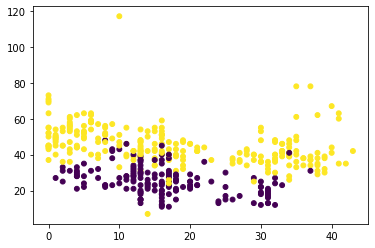

In [278]:
while max > eps:
  iterations += 1
  # Calling the expectation function.
  new_labels = expectation(df_copy.copy(), params)

  # Calling the maximization function
  new_parameters = maximization(new_labels, params.copy())

  # Calculating the difference between old and new parameters
  max = distance(params, new_parameters)

  # logging
  print("iteration {}, shift {}".format(iterations, max))

  # update labels and params for the next iteration
  df_copy = new_labels
  params = new_parameters
    #Plotting figure with label and attribute values
  fig = plt.figure()
  plt.scatter(df_copy['house_age'], df_copy['house_price_of_unit_area'], 24, c=df_copy['label'])
  fig.savefig("iteration{}.png".format(iterations))
